# Erreichbarkeit von Ärzten 

## Bibliotheken importieren

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from shapely.geometry import *
from scipy.spatial import Delaunay
from shapely.ops import cascaded_union, polygonize
import math
from matplotlib.lines import Line2D

import numpy as np
import osmnx as ox
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt
import shapely.geometry as geometry

## Graphen der einzelnen Fortbewegungsmitteln einladen

Funktion für das Einlesen des Graphens. 

Mit der Funktion graph_einladen kann ein OSM-Graph in xml-Format eingelesen und bei Bedarf vereinfacht werden. Die Funktion fragt, ob der Graph vereinfacht werden soll. Wenn ja, wird zusätzlich gefragt, ob auch Ellenbogenkreuzungen entfernt werden sollen. Zudem wird ein Attribut mit der Geschwindigkeit für alle Kanten hinzugefügt, sofern diese nicht existiert.

Eingabe:
- speicherort : string
- max_speed : float

Ausgabe:
- graph : networkx.MultiDiGraph

In [50]:
def graph_einladen(speicherort, max_speed):
    graph = ox.graph_from_xml(speicherort, simplify=False)
    if input('Graph vereinfachen?') == 'Ja':
        if input('Ellenbogenkreuzungen entfernen?')=='Ja':
            graph = ox.simplify_graph(graph, strict=True)
        else:
            graph = ox.simplify_graph(graph, strict=False)

    for u, v, data in graph.edges(data=True):
        if "maxspeed" not in data:
            # Wenn kein "maxspeed" vorhanden ist, auf den gewünschten Wert setzen
            data["maxspeed"] = max_speed
        else:
            if type(data['maxspeed']) == list:
                # Ist das Attribut 'maxspeed' eine Liste, wird der erste Wert der Liste gewählt
                data["maxspeed"] = int((data["maxspeed"][0]))
            else:
                data["maxspeed"] = int(data["maxspeed"])
            
    return graph

In [51]:
bus = graph_einladen('./Daten/osm/buslinien.osm', 18.5)
zug = graph_einladen('./Daten/osm/eisenbahn.osm', 80.56)
sbahn = graph_einladen('./Daten/osm/sbahn.osm', 40)

Zum zusammenfügen der Graphen, müssen diese zuerst in einer Liste abgelegt werden. 

In [52]:
graphs = [sbahn, bus, zug]
full_graph = nx.compose_all(graphs)

Funktion zum Zuschneiden des Graphens auf ein Bundesland.

Mit der Funktion zuschneiden kann der eingeladene Graph auf ein bestimmtes Bundesland zugeschnitten werden. Knoten und Kanten innerhlab des ausgewähltem Bundeslandes werden ermittelt. Der erstellte Graph wird in das angegebene Koordinatensystem projeziert.

Eingabe: 
- bundesland : string
- epsg : string

Ausgabe: 
- G : networkx.MultiDiGraph

In [57]:
def zuschneiden(bundesland, epsg):    
    grenze = gpd.read_file('./Daten/BundeslA4nder_2021_mit_Einwohnerzahl.geojson')
    gdf = grenze[grenze['GEN'] == bundesland]
    boundary = gdf.unary_union

    nodes_within_boundary = [node for node, data in full_graph.nodes(data=True) if boundary.contains(Point(data['x'], data['y']))]

    edges_within_boundary = [(u, v, key) for u, v, key, data in full_graph.edges(keys=True, data=True) if u in nodes_within_boundary and v in nodes_within_boundary]

    cropped_graph = full_graph.edge_subgraph(edges_within_boundary)
    G = cropped_graph
    G = ox.project_graph(G, to_crs=epsg)

    return G 

In [58]:
G = zuschneiden('Schleswig-Holstein', 'EPSG:25832')

Optional den Gesamtgraph abspeichern.

In [ ]:
#ox.save_graph_xml(G, './Daten/osm/gesamtgraph.osm')

Um später Isochronen zu berechnen, wird eine Spalte 'time' hinzugefügt, die jeder Kante einen enstprechenden Widerstand definiert. Der Widerstandswert entspricht der Reisezeit, die für die Kante unter Berücksichtigung der Geschwindigkeit gebraucht wird.

In [141]:
# Iterieren über jede Kante im Graphen
for u, v, data in G.edges(data=True):
    # Konvertieren von 'maxspeed' von String zu Float
    maxspeed = float(data['maxspeed'])

    # Berechnung der Zeit in Minuten und hinzufügen als 'time' zum Kantenattribut
    data['time'] = (data['length'] / maxspeed) * (60 / 1000)

### Eigenschaften Graph

Für die Ermittlung der Knotendichte, die Gesamtlänge des Graphens berechnen. Dafür wird über eine Schleife die Länger (Attribut length) jeder Kante aufsummiert. 

In [ ]:
# Variable für die Gesamtlänge
total_edge_length = 0

# Durchlaufen der Kanten und Aufaddieren der Längen zur Gesamtlänge
for u, v, k, data in G.edges(keys=True, data=True):
    if 'length' in data:
        total_edge_length += data['length']

print("Gesamtlänge der Kanten im Graphen:", total_edge_length, "Meter")

Die Gesamtanzahl der Knoten ermitteln.

In [ ]:
# Gesamtanzahl der Knoten im Graphen
anzahl_knoten = G.number_of_nodes()

print("Die Gesamtanzahl der Knoten im OSMnx-Graphen beträgt:", anzahl_knoten)

## Daten für die Gemeinden einlesen

In [ ]:
kreise_gdf = gpd.read_file("./Daten/Bevoelkerung/Anteil_Ue64_SH.geojson")

## Ärzte einladen

Einladen der Daten und Geometrien für die Ärzte.

In [59]:
# find the node and then project the graph to UTM
aerzte = gpd.read_file('./Daten/Aerzte/aerzte_general_sh.geojson')

### Reduzierung der Ärzte

Für Simulationen kann die Anzahl der Ärzte reduziert werden

#### 1. zufällige Reduzierung

Alternativ den für die Arbeitet erstellen zufälig reduzierten Datensatz einladen.

In [ ]:
#aerzte_zufaellig_reduziert = gpd.read_file('./Daten/Aerzte/zufaellig_reduziert.geojson')

Anzahl der Zeilen, die entfernt werden sollen (auf gerade Zahl gerundet). In diesem Fall sollen 30% (0.3) entfernt werden.

In [60]:
anzahl_zu_entfernen = round((len(aerzte)*0.3), 0)

Überprüfe, ob die Anzahl zu entfernen Zeilen größer oder gleich der Gesamtanzahl der Zeilen im Dataframe (Anzahl der Ärzte insgesamt) ist. Ist dies nicht der Fall, werden zufällig 30% der Zeilen (Ärzte) entfernt.

In [ ]:
# Auwahl zufällige Zeilen aus dem Dataframe 
zufallszeilen = aerzte.sample(n=int(anzahl_zu_entfernen))

# Entfernen ausgewählter Zeilen aus dem Dataframe
aerzte_zufaellig_reduziert = aerzte.drop(zufallszeilen.index)

Alternativ Abspeichern des reduzierten Arzt-Datensatzes als GeoJSON.

In [ ]:
#aerzte_zufaellig_reduziert.to_file('zufaellig_reduziert.geojson', driver = 'GeoJSON')

#### 2. gewichtete Reduzierung

Um nach dem Anteil der Ü64-Jöhrigen zu gewichten und zu entfernen, muss der Datensatz der Ärzte zuerst mit dem Anteil der Ü64 verschnitten werden.

In [ ]:
arzte_with_ant = gpd.sjoin(aerzte, kreise_gdf, how='left', op='within')[['amenity', 'healthcare','name', 'geometry', 'gen', 'ai0207']]

Der neue GDF muss nun nach den Werten der Spalte 'ai0207' (Anteil an Ü64) sortiert werden.

In [ ]:
gdf_sorted = arzte_with_ant.sort_values(by=['ai0207'])

Jetzt werden wieder anhand des Porzentsatzes die Zeilen von unten nach oben gelöscht, also zuerst die Ärzte, die in einem Kreis mit hohem Ü64 Anteil sind.

In [ ]:
# Auswahl der letzten Zeilen (anzahl_zu_entfernen) aus dem Dataframe 
zu_entfernende_zeilen = gdf_sorted.tail(int(anzahl_zu_entfernen))

# Entfernen der ausgewählten Zeilen aus dem Dataframe
aerzte_reduziert_gewichtet = gdf_sorted.drop(zu_entfernende_zeilen.index)

## Isochronen erstellen

Um die Isochronen zu erstellen, werden Alpha-Shapes verwendet. Diese Funktion wurde aus dem BEMUDA-Tool übernommen, um die Berechnung der Alpha-Shapes durchzuführen. Diese sind alternativ zu konvexen Hüllen.

In [72]:
def alpha_shape(points, alpha):
        """
        Compute the alpha shape (concave hull) of a set
        of points.
        @param points: Iterable container of points.
        @param alpha: alpha value to influence the
            gooeyness of the border. Smaller numbers
            don't fall inward as much as larger numbers.
            Too large, and you lose everything!
        """
        #print(geometry.MultiPoint(list(points)).convex_hull)
        if len(points) < 4:
            # When you have a triangle, there is no sense
            # in computing an alpha shape.
            return geometry.MultiPoint(list(points)).convex_hull
        
        def add_edge(edges, edge_points, coords, i, j):
            """
            Add a line between the i-th and j-th points,
            if not in the list already
            """
            if (i, j) in edges or (j, i) in edges:
                    # already added
                return
            edges.add( (i, j) )
            edge_points.append(coords[ [i, j] ])
        coords = np.array([point.coords[0]
                           for point in points])
        #print(coords)
        tri = Delaunay(coords)
        edges = set()
        edge_points = []
        # loop over triangles:
        # ia, ib, ic = indices of corner points of the
        # triangle
        for ia, ib, ic in tri.vertices:
            pa = coords[ia]
            pb = coords[ib]
            pc = coords[ic]
            # Lengths of sides of triangle
            a = math.sqrt((pa[0]-pb[0])**2 + (pa[1]-pb[1])**2)
            b = math.sqrt((pb[0]-pc[0])**2 + (pb[1]-pc[1])**2)
            c = math.sqrt((pc[0]-pa[0])**2 + (pc[1]-pa[1])**2)
            # Semiperimeter of triangle
            s = (a + b + c)/2.0
            # Area of triangle by Heron's formula
            area = math.sqrt(s*(s-a)*(s-b)*(s-c))
            circum_r = a*b*c/(4.0*area)
            # Here's the radius filter.
            #print circum_r
            if circum_r < 1.0/alpha:
                add_edge(edges, edge_points, coords, ia, ib)
                add_edge(edges, edge_points, coords, ib, ic)
                add_edge(edges, edge_points, coords, ic, ia)
        m = geometry.MultiLineString(edge_points)
        triangles = list(polygonize(m))
        return cascaded_union(triangles), edge_points

### Isochronen

Funktion zum Berechnen der Isochronen

Die Funktion iso dient dazu, die Isochronen mit Hilfe von Alpha-Shapes zu ermitteln. Von jedem Startpunkt aus wird eine Isochrone erstellt und diese in einem Geodataframe gespeichert. Die weite der Isochronen kann über den Radius (z.B. 5 für 5 Minuten) definiert werden und auch der Wert des Alphas für den Radius der Alpha-Shapes (1/alpha) ist variabel. 

Eingabe: 
- startpunkte : GeoDataFrame
- radius : integer
- alpha : float
- speichername : string


Ausgabe:
- gdf : GeoDataFrame 

In [169]:
def iso(startpunkte, radius, alpha,speichername):
    isochrone_polys = []
    for i in startpunkte.geometry:
        start = Point(i.x, i.y)
        s_p = ox.nearest_nodes(V, start.x, start.y)

        subgraph = nx.ego_graph(V, s_p, radius=radius, distance='time')
        node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
        bounding_poly = alpha_shape(gpd.GeoSeries(node_points), alpha=alpha)
        if type(bounding_poly) is tuple:
            isochrone_polys.append(bounding_poly[0])
        else: 
            isochrone_polys.append(bounding_poly)
        #isochrone_polys.append(bounding_poly)

    # Liste zur Speicherung der geometrischen Formen
    geometries = []

    # Durchlaufen Sie die Liste von Polygonen und konvertieren Sie sie in Shapely-Geometrien
    for poly in isochrone_polys:
        geometries.append(shape(poly))

    # Erstellen Sie eine GeoDataFrame mit den geometrischen Formen
    gdf = gpd.GeoDataFrame(geometry=geometries)
    gdf.to_file('./Isochronen/AlleKnoten/'+speichername+'.geojson', driver = 'GeoJSON', crs='EPSG:25832')
    return gdf

Isochronen für 5, 10, 15 und 20 Minuten für den nicht reduzierten Artzdatensatz erstellen.

In [171]:
gdf5 = iso(aerzte,5,0.0002,'5minuten_0002')
gdf10 = iso(aerzte,10,0.0002,'10minuten_0002')
gdf15 = iso(aerzte,15,0.0002,'15minuten_0002')
gdf20 = iso(aerzte,20,0.0002,'20minuten_0002')

## Visualisieren

Die Kanten extrahieren, um diese zu visualisieren

In [ ]:
egdes = ox.graph_to_gdfs(G, nodes=False)

Visualisierung der Isochronen für 5, 10, 15 und 20 Minuten inklusive einer Legende. 

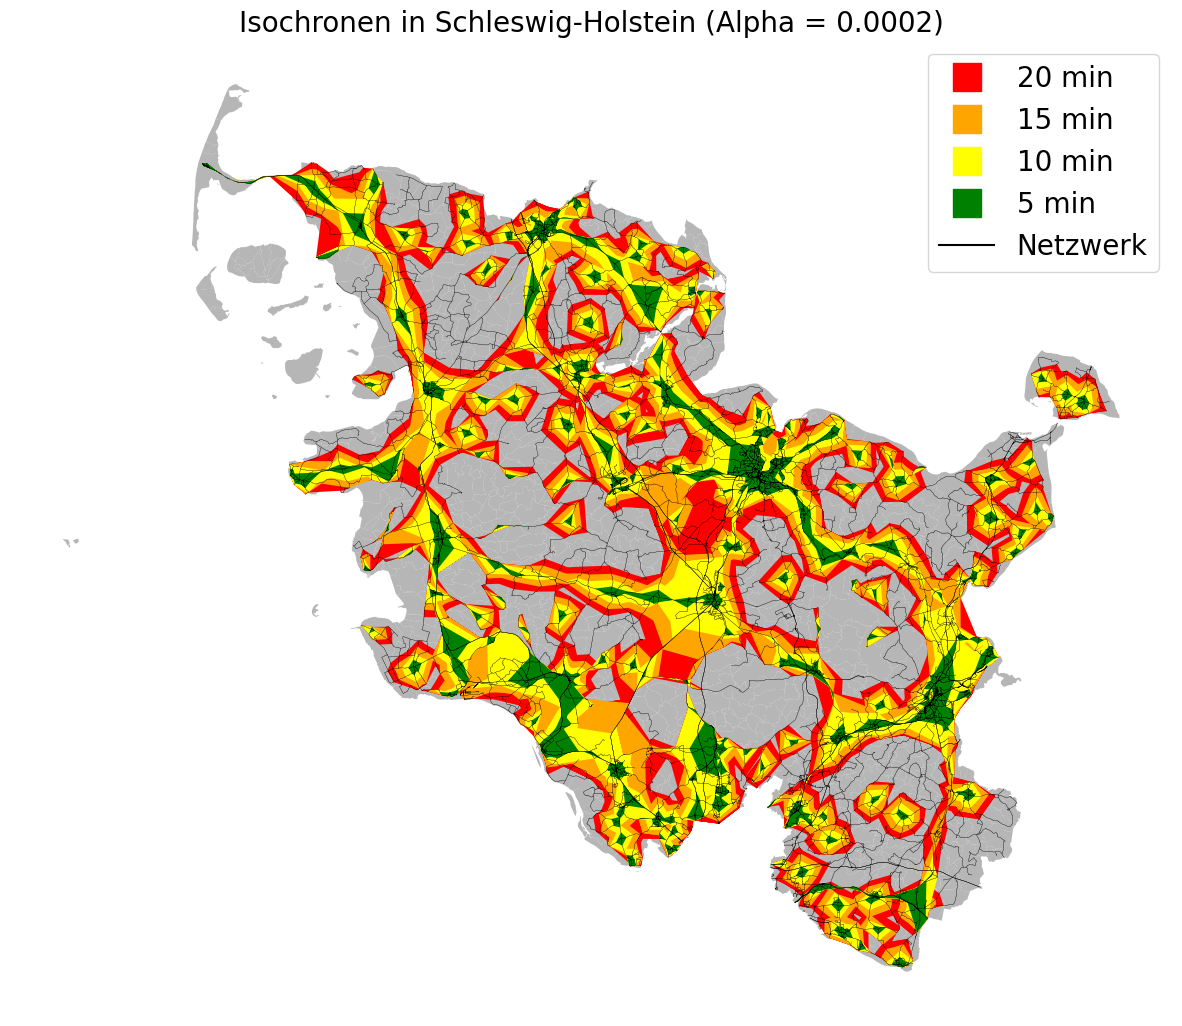

In [176]:
fig, ax = plt.subplots(1, figsize=(15, 15))
kreise_gdf.plot(ax=ax, color= 'darkgrey', alpha=0.85)
gdf20.plot(ax=ax, aspect=1, color = 'red', legend=True, label='20 min')
gdf15.plot(ax=ax, aspect=1, color = 'orange', legend=True, label='15 min')
gdf10.plot(ax=ax, aspect=1, color = 'yellow', legend=True, label='10 min')
gdf5.plot(ax=ax, aspect=1, color = 'green', legend=True, label='5 min')
#aerzte.plot(ax=ax, color='red', markersize = 15)
egdes.plot(ax=ax, color = 'black', lw = 0.15 ,legend =True)

# Legende erstellen mit den einzelnen Elementen
handles = [#Line2D([0], [0], linestyle='none', mfc='red', mec='red', marker='o', markersize=20, label='Ärzte'),
           Line2D([0], [0], linestyle='none', mfc='red', mec='red', marker='s', markersize=20, label='20 min'),
           Line2D([0], [0], linestyle='none', mfc='orange', mec='orange', marker='s', markersize=20, label='15 min'),
           Line2D([0], [0], linestyle='none', mfc='yellow', mec='yellow', marker='s', markersize=20, label='10 min'),
           Line2D([0], [0], linestyle='none', mfc='green', mec='green', marker='s', markersize=20, label='5 min'),
           #Line2D([0], [0], linestyle='none', mfc='red', mec='red', marker='o', markersize=20, label='Ärzte'),
           Line2D([0], [0], color='black', label='Netzwerk')]
plt.legend(handles=handles, fontsize=20, loc = 'upper right')

# Titel hinzufügen
ax.set_title('Isochronen in Schleswig-Holstein (Alpha = 0.0002)', fontsize = 20)
ax.set_axis_off()


plt.show()